In [1]:
from matplotlib import pyplot as plt
import time
import datetime
from utils_laj import *
from data_processing import get_SensorData, my_pca, series_to_supervised, lstm_sampling
from sklearn.model_selection import train_test_split
import pandas as pd

today = datetime.date.today()
TR_END = "2017-12-31 23:00:00"

In [2]:
path_checkpoint = './save/save_lstm/lstm_2_layers'
input_path = './input_data'
file = os.path.join(input_path,'sensors.csv')
target_file = os.path.join(input_path,'coke_target.csv')

In [3]:
# Считываем данные из файлов, нормализуем и применяем метод главных комполнентов
X, y, submit_X, mean_y, std_y = get_SensorData(file, target_file, nc=15)


feature shape: (13272, 48)
target length: (10400, 2)
Explained variance [0.61892923 0.08232462 0.05322641 0.04720283 0.03221503 0.02667573
 0.02214032 0.02059834 0.01678942 0.01440538 0.0116038  0.0062331
 0.00603211 0.00546633 0.00484757], Cumsum [0.61892923 0.70125384 0.75448025 0.80168309 0.83389811 0.86057385
 0.88271417 0.90331251 0.92010193 0.93450731 0.94611111 0.95234421
 0.95837632 0.96384265 0.96869022]


In [4]:
# Размерности датасета с известным целевым y и полного датасета
print("Data X: %s, y %s, submit_X %s" % (X.shape, y.shape, submit_X.shape))

Data X: (10400, 15), y (10400, 2), submit_X (13272, 15)


In [5]:
# выделим последние записи в размере контрольного датасета в тестовый датасет
x1_train, x1_test, y1_train, y1_test = train_test_split(X, y, test_size=2920, random_state=42, shuffle=False)

# Формируем сэмплы для LSTM по 48 рядов внахлест с шагом 1
timesteps = 48
lag = 1
i_train = len(x1_train) + timesteps  


x_train, y_train = lstm_sampling(X[:i_train], y=y[:i_train]['target'], timesteps=timesteps, lag=lag)
x_test, y_test = lstm_sampling(x1_test, y=y1_test['target'], timesteps=timesteps, lag=lag)
#yl = y['target'][timesteps:]

# формируем данные сабмита по аналогичному принципу + берем 47 шагов из тестовых данных
Xs, ys = lstm_sampling(submit_X, timesteps=timesteps, lag=lag)

print("Data x_train, y_train: (%s,%s);  x_test, y_test: (%s,%s); Xs, ys: (%s,%s) " % (x_train.shape, y_train.shape, x_test.shape, y_test.shape, Xs.shape, ys))



Samples length 7480
Targets length 7480
Samples length 2872
Targets length 2872
Samples length 13224
Targets length 0
Data x_train, y_train: ((7480, 48, 15),(7480, 48));  x_test, y_test: ((2872, 48, 15),(2872, 48)); Xs, ys: ((13224, 48, 15),None) 


In [6]:
    Train = True
    Predict = True
    plot = False

In [7]:
    batch_size = 359  # Batch size
    shift = batch_size
    #if Train == False: batch_size = 1

    sequence_length = timesteps  # Number of steps
    learning_rate = 4*10e-6  # 0.0001
    epochs = 1000
    ann_hidden = 16

    n_channels = x_train.shape[2]

    lstm_size = 48  # Number LSTM units
    num_layers = 2  # 2  # Number of layers
    alpha = 0 # regularization coef

In [8]:
    X = tf.placeholder(tf.float32, [None, sequence_length, n_channels], name='inputs')
    Y = tf.placeholder(tf.float32, [None, sequence_length], name='labels')
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')
    learning_rate_ = tf.placeholder(tf.float32, name='learning_rate')
    is_train = tf.placeholder(dtype=tf.bool, shape=None, name="is_train")

    conv_last_layer = X

    shape = conv_last_layer.get_shape().as_list()
    print('My Conv Shape:',shape)
    CNN_flat = tf.reshape(conv_last_layer, [-1, shape[1] * shape[2]])

    dence_layer_1 = dense_layer(CNN_flat, size=sequence_length * n_channels, activation_fn=tf.nn.relu, batch_norm=False,
                                phase=is_train, drop_out=True, keep_prob=keep_prob,
                                scope="fc_1")
    lstm_input = tf.reshape(dence_layer_1, [-1, sequence_length, n_channels])

    cell = get_RNNCell(['LSTM'] * num_layers, keep_prob=keep_prob, state_size=lstm_size)
    init_states = cell.zero_state(batch_size, tf.float32)
    
    # For each layer, get the initial state. states will be a tuple of LSTMStateTuples.
    states = get_state_variables(batch_size, cell)

    # Unroll the LSTM
    rnn_output, new_states = tf.nn.dynamic_rnn(cell, lstm_input, dtype=tf.float32, initial_state=states)
    
    # Add an operation to update the train states with the last state tensors.
    update_op = get_state_update_op(states, new_states)
    reset_op = get_state_update_op(states, init_states)
    
    stacked_rnn_output = tf.reshape(rnn_output, [-1, lstm_size])  # change the form into a tensor

    dence_layer_2 = dense_layer(stacked_rnn_output, size=ann_hidden, activation_fn=tf.nn.relu, batch_norm=False,
                                phase=is_train, drop_out=True, keep_prob=keep_prob,
                                scope="fc_2")
    
    dence_layer_3 = dense_layer(dence_layer_2, size=ann_hidden, activation_fn=tf.nn.relu, batch_norm=False,
                                phase=is_train, drop_out=True, keep_prob=keep_prob,
                                scope="fc_2_2")

    output = dense_layer(dence_layer_3, size=1, activation_fn=None, batch_norm=False, phase=is_train, drop_out=False,
                         keep_prob=keep_prob,
                         scope="fc_3_output")

    prediction = tf.reshape(output, [-1])
    y_flat = tf.reshape(Y, [-1])

    h = prediction - y_flat
    
    tv = tf.trainable_variables()
    regularization_cost = tf.reduce_sum([ tf.nn.l2_loss(v) for v in tv ])

    cost_function = tf.reduce_sum(tf.square(h)) + alpha*regularization_cost
    RMSE = tf.sqrt(tf.reduce_mean(tf.square(h)))
    optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost_function)

    saver = tf.train.Saver()
    
    training_generator = batch_generator(x_train, y_train, batch_size, sequence_length, online=True, online_shift=shift)
    testing_generator = batch_generator(x_test, y_test, batch_size, sequence_length, online=True, online_shift=shift)
    #print(len(list(training_generator)))

    if Train: model_summary(learning_rate=learning_rate, batch_size=batch_size, lstm_layers=num_layers,
                            lstm_layer_size=lstm_size, fc_layer_size=ann_hidden, sequence_length=sequence_length,
                            n_channels=n_channels, path_checkpoint=path_checkpoint, spacial_note='')
        


My Conv Shape: [None, 48, 15]


INFO:tensorflow:Restoring parameters from ./save/save_lstm/lstm_2_layers
Model restored from file: ./save/save_lstm/lstm_2_layers
Training set MSE
No epoches:  1000 No itr:  20
LSTM epoch: 0 RMSE-train: 0.45869008 RMSE-test 0.53392047 lr 4e-05 	time/epoch: 4.1 	time_remaining:  1  hr: 8.3  min 	time_stamp:  2018.11.16-01:11:08
LSTM epoch: 1 RMSE-train: 0.46054733 RMSE-test 0.53391314 lr 4e-05 	time/epoch: 3.05 	time_remaining:  0  hr: 50.9  min 	time_stamp:  2018.11.16-01:11:11
LSTM epoch: 2 RMSE-train: 0.46291405 RMSE-test 0.5340767 lr 4e-05 	time/epoch: 3.04 	time_remaining:  0  hr: 50.5  min 	time_stamp:  2018.11.16-01:11:14
LSTM epoch: 3 RMSE-train: 0.46140194 RMSE-test 0.5339218 lr 4e-05 	time/epoch: 3.05 	time_remaining:  0  hr: 50.7  min 	time_stamp:  2018.11.16-01:11:17
LSTM epoch: 4 RMSE-train: 0.46484092 RMSE-test 0.53365797 lr 4e-05 	time/epoch: 3.07 	time_remaining:  0  hr: 50.9  min 	time_stamp:  2018.11.16-01:11:20
LSTM epoch: 5 RMSE-train: 0.45989978 RMSE-test 0.53375477

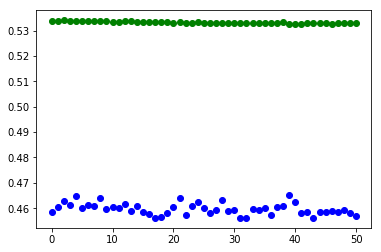

LSTM epoch: 51 RMSE-train: 0.4573281 RMSE-test 0.5328344 lr 4e-05 	time/epoch: 3.23 	time_remaining:  0  hr: 51.1  min 	time_stamp:  2018.11.16-01:13:43
LSTM epoch: 52 RMSE-train: 0.45674187 RMSE-test 0.53272116 lr 4e-05 	time/epoch: 3.06 	time_remaining:  0  hr: 48.4  min 	time_stamp:  2018.11.16-01:13:46
LSTM epoch: 53 RMSE-train: 0.46032876 RMSE-test 0.5329081 lr 4e-05 	time/epoch: 3.01 	time_remaining:  0  hr: 47.5  min 	time_stamp:  2018.11.16-01:13:49
LSTM epoch: 54 RMSE-train: 0.45853138 RMSE-test 0.5326087 lr 4e-05 	time/epoch: 3.12 	time_remaining:  0  hr: 49.1  min 	time_stamp:  2018.11.16-01:13:53
LSTM epoch: 55 RMSE-train: 0.45346802 RMSE-test 0.5327739 lr 4e-05 	time/epoch: 3.08 	time_remaining:  0  hr: 48.5  min 	time_stamp:  2018.11.16-01:13:56
LSTM epoch: 56 RMSE-train: 0.45516863 RMSE-test 0.53258044 lr 4e-05 	time/epoch: 2.98 	time_remaining:  0  hr: 46.9  min 	time_stamp:  2018.11.16-01:13:59
LSTM epoch: 57 RMSE-train: 0.45975515 RMSE-test 0.5326635 lr 4e-05 	time/ep

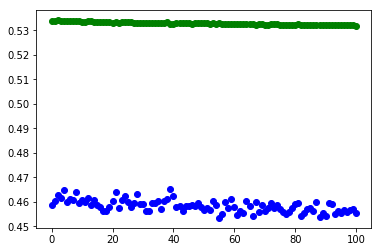

LSTM epoch: 101 RMSE-train: 0.45657712 RMSE-test 0.53190285 lr 4e-05 	time/epoch: 3.45 	time_remaining:  0  hr: 51.7  min 	time_stamp:  2018.11.16-01:16:16
LSTM epoch: 102 RMSE-train: 0.45617458 RMSE-test 0.5321066 lr 4e-05 	time/epoch: 3.06 	time_remaining:  0  hr: 45.8  min 	time_stamp:  2018.11.16-01:16:19
LSTM epoch: 103 RMSE-train: 0.459178 RMSE-test 0.5318282 lr 4e-05 	time/epoch: 3.02 	time_remaining:  0  hr: 45.2  min 	time_stamp:  2018.11.16-01:16:22
LSTM epoch: 104 RMSE-train: 0.4582531 RMSE-test 0.53182614 lr 4e-05 	time/epoch: 3.07 	time_remaining:  0  hr: 45.9  min 	time_stamp:  2018.11.16-01:16:25
LSTM epoch: 105 RMSE-train: 0.45755345 RMSE-test 0.53193426 lr 4e-05 	time/epoch: 3.07 	time_remaining:  0  hr: 45.8  min 	time_stamp:  2018.11.16-01:16:28
LSTM epoch: 106 RMSE-train: 0.4555917 RMSE-test 0.5317977 lr 4e-05 	time/epoch: 3.11 	time_remaining:  0  hr: 46.3  min 	time_stamp:  2018.11.16-01:16:31
LSTM epoch: 107 RMSE-train: 0.45438114 RMSE-test 0.5317801 lr 4e-05 	ti

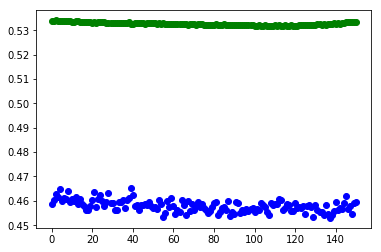

LSTM epoch: 151 RMSE-train: 0.45354843 RMSE-test 0.5334659 lr 4e-05 	time/epoch: 3.39 	time_remaining:  0  hr: 48.0  min 	time_stamp:  2018.11.16-01:18:48
LSTM epoch: 152 RMSE-train: 0.4558556 RMSE-test 0.53380996 lr 4e-05 	time/epoch: 3.0 	time_remaining:  0  hr: 42.4  min 	time_stamp:  2018.11.16-01:18:51
LSTM epoch: 153 RMSE-train: 0.45879954 RMSE-test 0.53409755 lr 4e-05 	time/epoch: 3.08 	time_remaining:  0  hr: 43.5  min 	time_stamp:  2018.11.16-01:18:55
LSTM epoch: 154 RMSE-train: 0.4600408 RMSE-test 0.5343127 lr 4e-05 	time/epoch: 3.1 	time_remaining:  0  hr: 43.7  min 	time_stamp:  2018.11.16-01:18:58
LSTM epoch: 155 RMSE-train: 0.45630476 RMSE-test 0.53405875 lr 4e-05 	time/epoch: 3.13 	time_remaining:  0  hr: 44.0  min 	time_stamp:  2018.11.16-01:19:01
LSTM epoch: 156 RMSE-train: 0.456767 RMSE-test 0.5343761 lr 4e-05 	time/epoch: 3.06 	time_remaining:  0  hr: 43.1  min 	time_stamp:  2018.11.16-01:19:04
LSTM epoch: 157 RMSE-train: 0.45437914 RMSE-test 0.5339819 lr 4e-05 	time

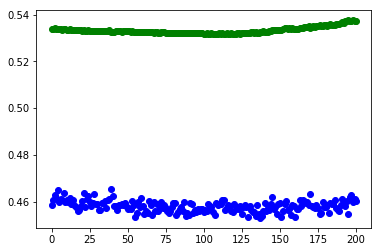

LSTM epoch: 201 RMSE-train: 0.45970035 RMSE-test 0.5378734 lr 4e-05 	time/epoch: 3.34 	time_remaining:  0  hr: 44.4  min 	time_stamp:  2018.11.16-01:21:22
LSTM epoch: 202 RMSE-train: 0.45992103 RMSE-test 0.5377479 lr 4e-05 	time/epoch: 3.06 	time_remaining:  0  hr: 40.7  min 	time_stamp:  2018.11.16-01:21:25
LSTM epoch: 203 RMSE-train: 0.4589516 RMSE-test 0.53733337 lr 4e-05 	time/epoch: 3.07 	time_remaining:  0  hr: 40.8  min 	time_stamp:  2018.11.16-01:21:28
LSTM epoch: 204 RMSE-train: 0.45474955 RMSE-test 0.53746104 lr 4e-05 	time/epoch: 3.07 	time_remaining:  0  hr: 40.7  min 	time_stamp:  2018.11.16-01:21:31
LSTM epoch: 205 RMSE-train: 0.45642385 RMSE-test 0.5372415 lr 4e-05 	time/epoch: 3.02 	time_remaining:  0  hr: 40.1  min 	time_stamp:  2018.11.16-01:21:34
LSTM epoch: 206 RMSE-train: 0.457407 RMSE-test 0.53749245 lr 4e-05 	time/epoch: 3.05 	time_remaining:  0  hr: 40.3  min 	time_stamp:  2018.11.16-01:21:37
LSTM epoch: 207 RMSE-train: 0.45858622 RMSE-test 0.537435 lr 4e-05 	ti

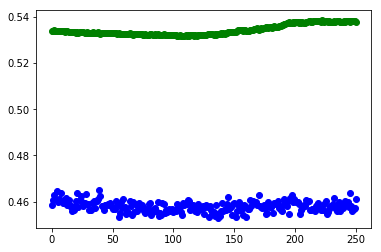

LSTM epoch: 251 RMSE-train: 0.46090937 RMSE-test 0.537977 lr 4e-05 	time/epoch: 3.28 	time_remaining:  0  hr: 41.0  min 	time_stamp:  2018.11.16-01:23:54
LSTM epoch: 252 RMSE-train: 0.45974073 RMSE-test 0.53791434 lr 4e-05 	time/epoch: 3.04 	time_remaining:  0  hr: 37.9  min 	time_stamp:  2018.11.16-01:23:57
LSTM epoch: 253 RMSE-train: 0.458968 RMSE-test 0.5379151 lr 4e-05 	time/epoch: 3.1 	time_remaining:  0  hr: 38.5  min 	time_stamp:  2018.11.16-01:24:00
LSTM epoch: 254 RMSE-train: 0.45835748 RMSE-test 0.53765 lr 4e-05 	time/epoch: 3.08 	time_remaining:  0  hr: 38.3  min 	time_stamp:  2018.11.16-01:24:03
LSTM epoch: 255 RMSE-train: 0.45570973 RMSE-test 0.53796273 lr 4e-05 	time/epoch: 3.05 	time_remaining:  0  hr: 37.9  min 	time_stamp:  2018.11.16-01:24:06
LSTM epoch: 256 RMSE-train: 0.45597517 RMSE-test 0.53801626 lr 4e-05 	time/epoch: 3.06 	time_remaining:  0  hr: 38.0  min 	time_stamp:  2018.11.16-01:24:09
LSTM epoch: 257 RMSE-train: 0.4542921 RMSE-test 0.5379841 lr 4e-05 	time/

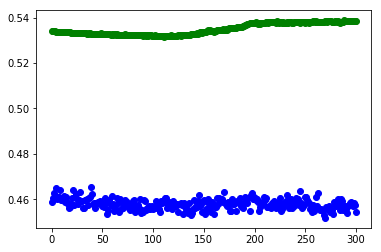

LSTM epoch: 301 RMSE-train: 0.45515305 RMSE-test 0.5386934 lr 4e-05 	time/epoch: 3.28 	time_remaining:  0  hr: 38.2  min 	time_stamp:  2018.11.16-01:26:27
LSTM epoch: 302 RMSE-train: 0.45327762 RMSE-test 0.53837866 lr 4e-05 	time/epoch: 3.05 	time_remaining:  0  hr: 35.5  min 	time_stamp:  2018.11.16-01:26:30
LSTM epoch: 303 RMSE-train: 0.4576823 RMSE-test 0.5380671 lr 4e-05 	time/epoch: 2.95 	time_remaining:  0  hr: 34.3  min 	time_stamp:  2018.11.16-01:26:33
LSTM epoch: 304 RMSE-train: 0.4531757 RMSE-test 0.5383538 lr 4e-05 	time/epoch: 3.04 	time_remaining:  0  hr: 35.3  min 	time_stamp:  2018.11.16-01:26:36
LSTM epoch: 305 RMSE-train: 0.45493573 RMSE-test 0.5380193 lr 4e-05 	time/epoch: 3.08 	time_remaining:  0  hr: 35.7  min 	time_stamp:  2018.11.16-01:26:39
LSTM epoch: 306 RMSE-train: 0.45410094 RMSE-test 0.53833467 lr 4e-05 	time/epoch: 3.1 	time_remaining:  0  hr: 35.8  min 	time_stamp:  2018.11.16-01:26:42
LSTM epoch: 307 RMSE-train: 0.45471138 RMSE-test 0.53845733 lr 4e-05 	t

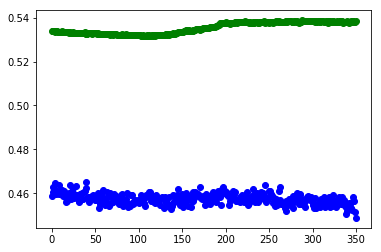

LSTM epoch: 351 RMSE-train: 0.45045686 RMSE-test 0.53847706 lr 4e-05 	time/epoch: 3.27 	time_remaining:  0  hr: 35.4  min 	time_stamp:  2018.11.16-01:29:00
LSTM epoch: 352 RMSE-train: 0.45636046 RMSE-test 0.5382571 lr 4e-05 	time/epoch: 3.03 	time_remaining:  0  hr: 32.8  min 	time_stamp:  2018.11.16-01:29:03
LSTM epoch: 353 RMSE-train: 0.45734078 RMSE-test 0.5384226 lr 4e-05 	time/epoch: 3.09 	time_remaining:  0  hr: 33.3  min 	time_stamp:  2018.11.16-01:29:06
LSTM epoch: 354 RMSE-train: 0.4571859 RMSE-test 0.5381823 lr 4e-05 	time/epoch: 3.03 	time_remaining:  0  hr: 32.6  min 	time_stamp:  2018.11.16-01:29:09
LSTM epoch: 355 RMSE-train: 0.4547592 RMSE-test 0.5382255 lr 4e-05 	time/epoch: 3.06 	time_remaining:  0  hr: 32.9  min 	time_stamp:  2018.11.16-01:29:12
LSTM epoch: 356 RMSE-train: 0.45436418 RMSE-test 0.53817475 lr 4e-05 	time/epoch: 3.01 	time_remaining:  0  hr: 32.3  min 	time_stamp:  2018.11.16-01:29:15
LSTM epoch: 357 RMSE-train: 0.4550954 RMSE-test 0.5381084 lr 4e-05 	ti

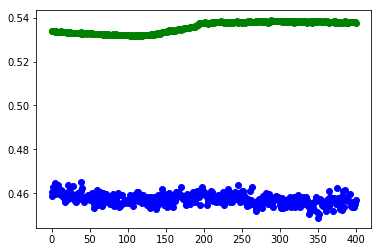

LSTM epoch: 401 RMSE-train: 0.45451507 RMSE-test 0.5383477 lr 2e-05 	time/epoch: 3.38 	time_remaining:  0  hr: 33.8  min 	time_stamp:  2018.11.16-01:31:32
LSTM epoch: 402 RMSE-train: 0.45556158 RMSE-test 0.5379736 lr 2e-05 	time/epoch: 3.08 	time_remaining:  0  hr: 30.7  min 	time_stamp:  2018.11.16-01:31:35
LSTM epoch: 403 RMSE-train: 0.4599435 RMSE-test 0.53775495 lr 2e-05 	time/epoch: 3.02 	time_remaining:  0  hr: 30.1  min 	time_stamp:  2018.11.16-01:31:38
LSTM epoch: 404 RMSE-train: 0.4535849 RMSE-test 0.53757006 lr 2e-05 	time/epoch: 3.06 	time_remaining:  0  hr: 30.4  min 	time_stamp:  2018.11.16-01:31:41
LSTM epoch: 405 RMSE-train: 0.4551585 RMSE-test 0.53803444 lr 2e-05 	time/epoch: 3.01 	time_remaining:  0  hr: 29.8  min 	time_stamp:  2018.11.16-01:31:44
LSTM epoch: 406 RMSE-train: 0.455628 RMSE-test 0.5378188 lr 2e-05 	time/epoch: 3.06 	time_remaining:  0  hr: 30.3  min 	time_stamp:  2018.11.16-01:31:48
LSTM epoch: 407 RMSE-train: 0.4576797 RMSE-test 0.537619 lr 2e-05 	time/

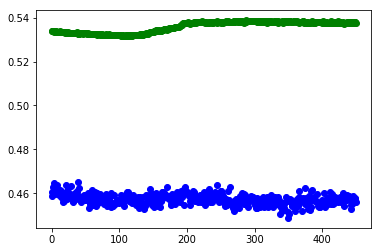

LSTM epoch: 451 RMSE-train: 0.45413575 RMSE-test 0.53809726 lr 2e-05 	time/epoch: 3.32 	time_remaining:  0  hr: 30.4  min 	time_stamp:  2018.11.16-01:34:05
LSTM epoch: 452 RMSE-train: 0.45625734 RMSE-test 0.5377892 lr 2e-05 	time/epoch: 3.08 	time_remaining:  0  hr: 28.2  min 	time_stamp:  2018.11.16-01:34:08
LSTM epoch: 453 RMSE-train: 0.4564749 RMSE-test 0.5379628 lr 2e-05 	time/epoch: 3.05 	time_remaining:  0  hr: 27.8  min 	time_stamp:  2018.11.16-01:34:11
LSTM epoch: 454 RMSE-train: 0.4575721 RMSE-test 0.5373829 lr 2e-05 	time/epoch: 3.08 	time_remaining:  0  hr: 28.0  min 	time_stamp:  2018.11.16-01:34:14
LSTM epoch: 455 RMSE-train: 0.45808756 RMSE-test 0.53792155 lr 2e-05 	time/epoch: 3.05 	time_remaining:  0  hr: 27.7  min 	time_stamp:  2018.11.16-01:34:17
LSTM epoch: 456 RMSE-train: 0.45838743 RMSE-test 0.53774446 lr 2e-05 	time/epoch: 3.1 	time_remaining:  0  hr: 28.1  min 	time_stamp:  2018.11.16-01:34:20
LSTM epoch: 457 RMSE-train: 0.45630047 RMSE-test 0.53766894 lr 2e-05 	

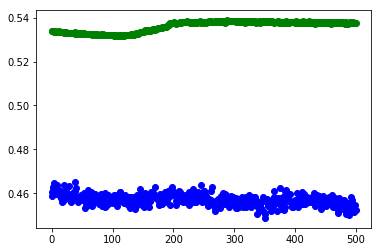

LSTM epoch: 501 RMSE-train: 0.4539065 RMSE-test 0.5379147 lr 2e-05 	time/epoch: 3.44 	time_remaining:  0  hr: 28.6  min 	time_stamp:  2018.11.16-01:36:38
LSTM epoch: 502 RMSE-train: 0.4524749 RMSE-test 0.537977 lr 2e-05 	time/epoch: 2.99 	time_remaining:  0  hr: 24.8  min 	time_stamp:  2018.11.16-01:36:41
LSTM epoch: 503 RMSE-train: 0.4561738 RMSE-test 0.537949 lr 2e-05 	time/epoch: 3.04 	time_remaining:  0  hr: 25.2  min 	time_stamp:  2018.11.16-01:36:44
LSTM epoch: 504 RMSE-train: 0.45248413 RMSE-test 0.53775096 lr 2e-05 	time/epoch: 3.03 	time_remaining:  0  hr: 25.1  min 	time_stamp:  2018.11.16-01:36:47
LSTM epoch: 505 RMSE-train: 0.4528365 RMSE-test 0.537887 lr 2e-05 	time/epoch: 3.1 	time_remaining:  0  hr: 25.6  min 	time_stamp:  2018.11.16-01:36:50
LSTM epoch: 506 RMSE-train: 0.4546333 RMSE-test 0.53748125 lr 2e-05 	time/epoch: 3.05 	time_remaining:  0  hr: 25.1  min 	time_stamp:  2018.11.16-01:36:53
LSTM epoch: 507 RMSE-train: 0.45640796 RMSE-test 0.53752995 lr 2e-05 	time/ep

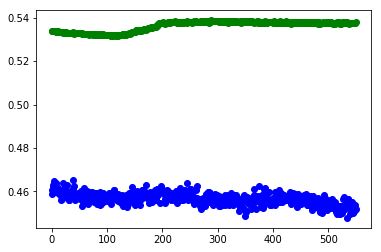

LSTM epoch: 551 RMSE-train: 0.45170245 RMSE-test 0.53754514 lr 2e-05 	time/epoch: 3.26 	time_remaining:  0  hr: 24.4  min 	time_stamp:  2018.11.16-01:39:12
LSTM epoch: 552 RMSE-train: 0.45502615 RMSE-test 0.53735536 lr 2e-05 	time/epoch: 3.1 	time_remaining:  0  hr: 23.1  min 	time_stamp:  2018.11.16-01:39:15
LSTM epoch: 553 RMSE-train: 0.4555472 RMSE-test 0.53763115 lr 2e-05 	time/epoch: 3.07 	time_remaining:  0  hr: 22.9  min 	time_stamp:  2018.11.16-01:39:18
LSTM epoch: 554 RMSE-train: 0.45458287 RMSE-test 0.53733367 lr 2e-05 	time/epoch: 3.05 	time_remaining:  0  hr: 22.7  min 	time_stamp:  2018.11.16-01:39:21
LSTM epoch: 555 RMSE-train: 0.4525744 RMSE-test 0.5375324 lr 2e-05 	time/epoch: 3.01 	time_remaining:  0  hr: 22.4  min 	time_stamp:  2018.11.16-01:39:24
LSTM epoch: 556 RMSE-train: 0.4521843 RMSE-test 0.53767073 lr 2e-05 	time/epoch: 3.07 	time_remaining:  0  hr: 22.7  min 	time_stamp:  2018.11.16-01:39:27
LSTM epoch: 557 RMSE-train: 0.45460266 RMSE-test 0.53770953 lr 2e-05 

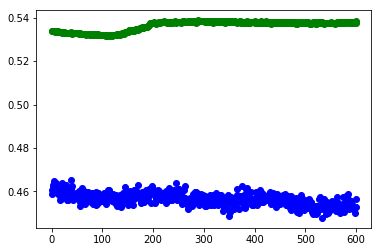

LSTM epoch: 601 RMSE-train: 0.45593193 RMSE-test 0.53780836 lr 2e-05 	time/epoch: 3.27 	time_remaining:  0  hr: 21.7  min 	time_stamp:  2018.11.16-01:41:46
LSTM epoch: 602 RMSE-train: 0.45639682 RMSE-test 0.5381183 lr 2e-05 	time/epoch: 3.17 	time_remaining:  0  hr: 21.1  min 	time_stamp:  2018.11.16-01:41:49
LSTM epoch: 603 RMSE-train: 0.45362076 RMSE-test 0.538017 lr 2e-05 	time/epoch: 3.07 	time_remaining:  0  hr: 20.3  min 	time_stamp:  2018.11.16-01:41:52
LSTM epoch: 604 RMSE-train: 0.45497388 RMSE-test 0.5379842 lr 2e-05 	time/epoch: 2.97 	time_remaining:  0  hr: 19.6  min 	time_stamp:  2018.11.16-01:41:55
LSTM epoch: 605 RMSE-train: 0.45307237 RMSE-test 0.53771836 lr 2e-05 	time/epoch: 3.07 	time_remaining:  0  hr: 20.2  min 	time_stamp:  2018.11.16-01:41:58
LSTM epoch: 606 RMSE-train: 0.45216534 RMSE-test 0.5380724 lr 2e-05 	time/epoch: 3.09 	time_remaining:  0  hr: 20.3  min 	time_stamp:  2018.11.16-01:42:01
LSTM epoch: 607 RMSE-train: 0.4553752 RMSE-test 0.5373739 lr 2e-05 	t

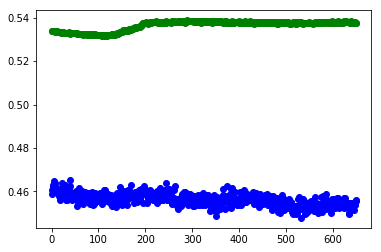

LSTM epoch: 651 RMSE-train: 0.45326003 RMSE-test 0.53760314 lr 2e-05 	time/epoch: 3.3 	time_remaining:  0  hr: 19.2  min 	time_stamp:  2018.11.16-01:44:20
LSTM epoch: 652 RMSE-train: 0.4558123 RMSE-test 0.5379467 lr 2e-05 	time/epoch: 3.14 	time_remaining:  0  hr: 18.2  min 	time_stamp:  2018.11.16-01:44:23
LSTM epoch: 653 RMSE-train: 0.45142928 RMSE-test 0.5377214 lr 2e-05 	time/epoch: 3.06 	time_remaining:  0  hr: 17.7  min 	time_stamp:  2018.11.16-01:44:26
LSTM epoch: 654 RMSE-train: 0.45284793 RMSE-test 0.5379053 lr 2e-05 	time/epoch: 3.12 	time_remaining:  0  hr: 18.0  min 	time_stamp:  2018.11.16-01:44:29
LSTM epoch: 655 RMSE-train: 0.45464897 RMSE-test 0.53840387 lr 2e-05 	time/epoch: 3.08 	time_remaining:  0  hr: 17.7  min 	time_stamp:  2018.11.16-01:44:32
LSTM epoch: 656 RMSE-train: 0.45551148 RMSE-test 0.538019 lr 2e-05 	time/epoch: 3.09 	time_remaining:  0  hr: 17.7  min 	time_stamp:  2018.11.16-01:44:36
LSTM epoch: 657 RMSE-train: 0.45414218 RMSE-test 0.537783 lr 2e-05 	tim

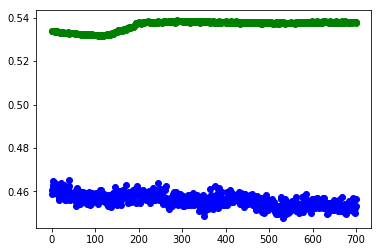

LSTM epoch: 701 RMSE-train: 0.4514466 RMSE-test 0.5377196 lr 2e-05 	time/epoch: 3.45 	time_remaining:  0  hr: 17.2  min 	time_stamp:  2018.11.16-01:46:54
LSTM epoch: 702 RMSE-train: 0.4544695 RMSE-test 0.5379134 lr 2e-05 	time/epoch: 3.01 	time_remaining:  0  hr: 14.9  min 	time_stamp:  2018.11.16-01:46:57
LSTM epoch: 703 RMSE-train: 0.45115566 RMSE-test 0.5382106 lr 2e-05 	time/epoch: 2.99 	time_remaining:  0  hr: 14.8  min 	time_stamp:  2018.11.16-01:47:00
LSTM epoch: 704 RMSE-train: 0.45778733 RMSE-test 0.53824073 lr 2e-05 	time/epoch: 3.06 	time_remaining:  0  hr: 15.1  min 	time_stamp:  2018.11.16-01:47:03
LSTM epoch: 705 RMSE-train: 0.45466137 RMSE-test 0.53860563 lr 2e-05 	time/epoch: 3.11 	time_remaining:  0  hr: 15.3  min 	time_stamp:  2018.11.16-01:47:06
LSTM epoch: 706 RMSE-train: 0.44931158 RMSE-test 0.5384913 lr 2e-05 	time/epoch: 3.04 	time_remaining:  0  hr: 14.9  min 	time_stamp:  2018.11.16-01:47:09
LSTM epoch: 707 RMSE-train: 0.4497008 RMSE-test 0.53806835 lr 2e-05 	t

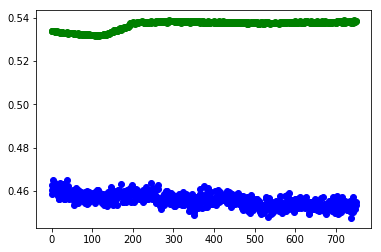

LSTM epoch: 751 RMSE-train: 0.4519873 RMSE-test 0.53801066 lr 2e-05 	time/epoch: 3.29 	time_remaining:  0  hr: 13.6  min 	time_stamp:  2018.11.16-01:49:28
LSTM epoch: 752 RMSE-train: 0.454952 RMSE-test 0.538633 lr 2e-05 	time/epoch: 2.99 	time_remaining:  0  hr: 12.4  min 	time_stamp:  2018.11.16-01:49:31
LSTM epoch: 753 RMSE-train: 0.45396504 RMSE-test 0.53789955 lr 2e-05 	time/epoch: 3.07 	time_remaining:  0  hr: 12.7  min 	time_stamp:  2018.11.16-01:49:34
LSTM epoch: 754 RMSE-train: 0.45100886 RMSE-test 0.53804433 lr 2e-05 	time/epoch: 3.15 	time_remaining:  0  hr: 12.9  min 	time_stamp:  2018.11.16-01:49:37
LSTM epoch: 755 RMSE-train: 0.45146844 RMSE-test 0.5384097 lr 2e-05 	time/epoch: 3.05 	time_remaining:  0  hr: 12.5  min 	time_stamp:  2018.11.16-01:49:40
LSTM epoch: 756 RMSE-train: 0.4559581 RMSE-test 0.5381974 lr 2e-05 	time/epoch: 3.09 	time_remaining:  0  hr: 12.6  min 	time_stamp:  2018.11.16-01:49:43
LSTM epoch: 757 RMSE-train: 0.4543119 RMSE-test 0.53813875 lr 2e-05 	tim

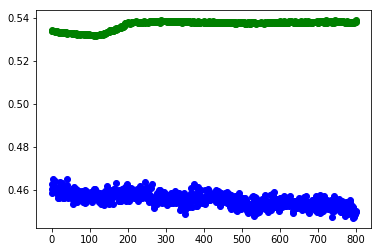

LSTM epoch: 801 RMSE-train: 0.44987124 RMSE-test 0.53794515 lr 1e-05 	time/epoch: 3.43 	time_remaining:  0  hr: 11.4  min 	time_stamp:  2018.11.16-01:52:02
LSTM epoch: 802 RMSE-train: 0.45079198 RMSE-test 0.5379028 lr 1e-05 	time/epoch: 3.03 	time_remaining:  0  hr: 10.0  min 	time_stamp:  2018.11.16-01:52:05
LSTM epoch: 803 RMSE-train: 0.4492826 RMSE-test 0.5381448 lr 1e-05 	time/epoch: 3.02 	time_remaining:  0  hr: 9.9  min 	time_stamp:  2018.11.16-01:52:08
LSTM epoch: 804 RMSE-train: 0.45154503 RMSE-test 0.5381907 lr 1e-05 	time/epoch: 3.1 	time_remaining:  0  hr: 10.1  min 	time_stamp:  2018.11.16-01:52:11
LSTM epoch: 805 RMSE-train: 0.44972903 RMSE-test 0.5381626 lr 1e-05 	time/epoch: 3.09 	time_remaining:  0  hr: 10.0  min 	time_stamp:  2018.11.16-01:52:14
LSTM epoch: 806 RMSE-train: 0.45229998 RMSE-test 0.53821665 lr 1e-05 	time/epoch: 3.07 	time_remaining:  0  hr: 9.9  min 	time_stamp:  2018.11.16-01:52:17
LSTM epoch: 807 RMSE-train: 0.4508024 RMSE-test 0.537926 lr 1e-05 	time/

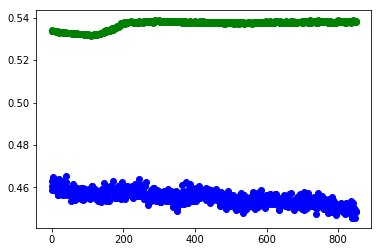

LSTM epoch: 851 RMSE-train: 0.44765458 RMSE-test 0.538308 lr 1e-05 	time/epoch: 3.28 	time_remaining:  0  hr: 8.1  min 	time_stamp:  2018.11.16-01:54:36
LSTM epoch: 852 RMSE-train: 0.449187 RMSE-test 0.5381708 lr 1e-05 	time/epoch: 3.04 	time_remaining:  0  hr: 7.5  min 	time_stamp:  2018.11.16-01:54:39
LSTM epoch: 853 RMSE-train: 0.45133963 RMSE-test 0.53765076 lr 1e-05 	time/epoch: 3.11 	time_remaining:  0  hr: 7.6  min 	time_stamp:  2018.11.16-01:54:42
LSTM epoch: 854 RMSE-train: 0.45100597 RMSE-test 0.5382782 lr 1e-05 	time/epoch: 3.09 	time_remaining:  0  hr: 7.5  min 	time_stamp:  2018.11.16-01:54:45
LSTM epoch: 855 RMSE-train: 0.45238698 RMSE-test 0.5382277 lr 1e-05 	time/epoch: 3.03 	time_remaining:  0  hr: 7.3  min 	time_stamp:  2018.11.16-01:54:48
LSTM epoch: 856 RMSE-train: 0.4475213 RMSE-test 0.5385789 lr 1e-05 	time/epoch: 3.12 	time_remaining:  0  hr: 7.5  min 	time_stamp:  2018.11.16-01:54:51
LSTM epoch: 857 RMSE-train: 0.45108756 RMSE-test 0.5381159 lr 1e-05 	time/epoch

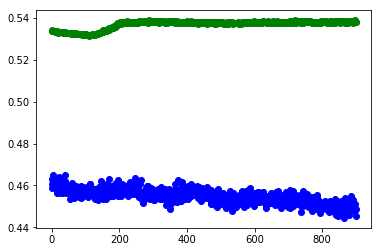

LSTM epoch: 901 RMSE-train: 0.44869432 RMSE-test 0.53796643 lr 1e-05 	time/epoch: 3.31 	time_remaining:  0  hr: 5.5  min 	time_stamp:  2018.11.16-01:57:10
LSTM epoch: 902 RMSE-train: 0.4513742 RMSE-test 0.5381287 lr 1e-05 	time/epoch: 3.11 	time_remaining:  0  hr: 5.1  min 	time_stamp:  2018.11.16-01:57:13
LSTM epoch: 903 RMSE-train: 0.4487971 RMSE-test 0.5381845 lr 1e-05 	time/epoch: 3.1 	time_remaining:  0  hr: 5.0  min 	time_stamp:  2018.11.16-01:57:16
LSTM epoch: 904 RMSE-train: 0.4535945 RMSE-test 0.5379332 lr 1e-05 	time/epoch: 3.16 	time_remaining:  0  hr: 5.0  min 	time_stamp:  2018.11.16-01:57:19
LSTM epoch: 905 RMSE-train: 0.45021603 RMSE-test 0.5377751 lr 1e-05 	time/epoch: 3.14 	time_remaining:  0  hr: 5.0  min 	time_stamp:  2018.11.16-01:57:22
LSTM epoch: 906 RMSE-train: 0.45311788 RMSE-test 0.53850734 lr 1e-05 	time/epoch: 3.07 	time_remaining:  0  hr: 4.8  min 	time_stamp:  2018.11.16-01:57:26
LSTM epoch: 907 RMSE-train: 0.4499927 RMSE-test 0.5380847 lr 1e-05 	time/epoch

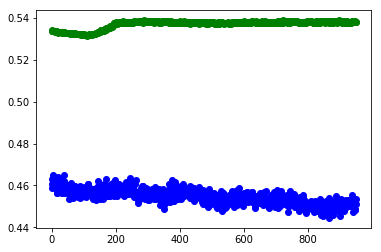

LSTM epoch: 951 RMSE-train: 0.44989634 RMSE-test 0.5381809 lr 1e-05 	time/epoch: 3.33 	time_remaining:  0  hr: 2.7  min 	time_stamp:  2018.11.16-01:59:44
LSTM epoch: 952 RMSE-train: 0.45432827 RMSE-test 0.537911 lr 1e-05 	time/epoch: 3.09 	time_remaining:  0  hr: 2.5  min 	time_stamp:  2018.11.16-01:59:47
LSTM epoch: 953 RMSE-train: 0.44892213 RMSE-test 0.5380413 lr 1e-05 	time/epoch: 3.04 	time_remaining:  0  hr: 2.4  min 	time_stamp:  2018.11.16-01:59:50
LSTM epoch: 954 RMSE-train: 0.4507005 RMSE-test 0.53789705 lr 1e-05 	time/epoch: 3.05 	time_remaining:  0  hr: 2.3  min 	time_stamp:  2018.11.16-01:59:53
LSTM epoch: 955 RMSE-train: 0.450748 RMSE-test 0.53813654 lr 1e-05 	time/epoch: 3.01 	time_remaining:  0  hr: 2.3  min 	time_stamp:  2018.11.16-01:59:56
LSTM epoch: 956 RMSE-train: 0.45018563 RMSE-test 0.5379389 lr 1e-05 	time/epoch: 3.0 	time_remaining:  0  hr: 2.2  min 	time_stamp:  2018.11.16-01:59:59
LSTM epoch: 957 RMSE-train: 0.45178843 RMSE-test 0.53817374 lr 1e-05 	time/epoc

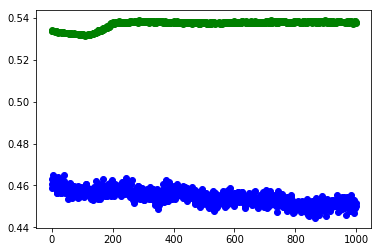

In [9]:
    with tf.Session() as session:
        tf.global_variables_initializer().run()

        if Train == True:
            saver.restore(session, path_checkpoint)
            print("Model restored from file: %s" % path_checkpoint)

            cost = []
            plot_x = []
            plot_y1 = []
            plot_y2 = []
            iter_train = int(x_train.shape[0]/shift)
            iter_test = int(x_test.shape[0]/shift)
            print("Training set MSE")
            print("No epoches: ", epochs, "No itr: ", iter_train)
            __start = time.time()
            for ep in range(epochs):
                session.run(reset_op)
                
                h1 = []
                t1 = []
                   
                for itr in range(iter_train):
                    ## training ##
                    batch_x, batch_y = next(training_generator)
                    #print("states:",session.run(states))
                    session.run([optimizer, update_op],
                                feed_dict={X: batch_x, Y: batch_y, keep_prob: 0.7, learning_rate_: learning_rate})
                    h_i = h.eval(feed_dict={X: batch_x, Y: batch_y, keep_prob: 1.0, learning_rate_: learning_rate})
                    cost.append(np.square(h_i))
                    h1.append(h_i)

                rmse_train = np.sqrt(np.mean(np.square(h1)))
                
                y_pred = []
                for itr in range(iter_test):
                    x_test_batch, y_test_batch = next(testing_generator)
                    #print("states:",session.run(states))
                    h_i, u = session.run([h, update_op], feed_dict={X: x_test_batch, Y: y_test_batch, keep_prob: 1.0, learning_rate_: learning_rate})
                    #session.run(update_op)
                    t1.append(h_i)
                
                rmse_test = np.sqrt(np.mean(np.square(t1)))
                
                #rmse_train = session.run(RMSE, feed_dict={X: batch_x, Y: batch_y, keep_prob: 1.0})
                rmse_test = session.run(RMSE, feed_dict={X: x_test_batch, Y: y_test_batch, keep_prob: 1.0})
                plot_x.append(ep)
                plot_y1.append(rmse_train)
                plot_y2.append(rmse_test)
                
                #print(ep)

                time_per_ep = (time.time() - __start)
                time_remaining = ((epochs - ep) * time_per_ep) / 3600
                print("LSTM", "epoch:", ep, "RMSE-train:", rmse_train, "RMSE-test", rmse_test, "lr", learning_rate,
                      "\ttime/epoch:", round(time_per_ep, 2), "\ttime_remaining: ",
                      int(time_remaining), " hr:", round((time_remaining % 1) * 60, 1), " min", "\ttime_stamp: ",
                      datetime.datetime.now().strftime("%Y.%m.%d-%H:%M:%S"))
                __start = time.time()

                if ep % 100 == 0 and ep != 0:
                    save_path = saver.save(session, path_checkpoint)
                    if os.path.exists(path_checkpoint + '.meta'):
                        print("Model saved to file: %s" % path_checkpoint)
                    else:
                        print("NOT SAVED!!!", path_checkpoint)

                if ep % 50 == 0 and ep != 0: 
                    plt.plot(plot_x, plot_y1, 'bo', plot_x, plot_y2, 'go')
                    plt.show()
                        
                if ep % 400 == 0 and ep != 0: 
                    learning_rate = learning_rate / 2


            save_path = saver.save(session, path_checkpoint)
            if os.path.exists(path_checkpoint + '.meta'):
                print("Model saved to file: %s" % path_checkpoint)
            else:
                print("NOT SAVED!!!", path_checkpoint)
            plt.plot(plot_x, plot_y1, 'bo', plot_x, plot_y2, 'go')
            plt.show()
        else:
            saver.restore(session, path_checkpoint)
            print("Model restored from file: %s" % path_checkpoint)
            if Predict == True:
                print("Prediction for submit...")
                x_predict = Xs
                y_predict = np.zeros((Xs.shape[0],Xs.shape[1]))

                predict_generator = batch_generator(x_predict, y_predict, batch_size, sequence_length,
                                                       online=True, online_shift=shift)

                full_prediction = []

                iteration = int(x_predict.shape[0] / shift)
                #print("iteration: %i, predgen %s" % (iteration, predict_generator))
                print("#of validation points:", x_predict.shape[0], "#datapoints covers from minibatch:",
                      batch_size * sequence_length, "iterations/epoch", iteration)

                for itr in range(iteration):
                    x_validate_batch, y_validate_batch = next(predict_generator)
                    #print (itr)
                    __y_pred, u = session.run([output, update_op], feed_dict={X: x_validate_batch, Y: y_validate_batch, keep_prob: 1.0})
                    #session.run(update_op)
                    for i in range(batch_size):
                        full_prediction.append(__y_pred[i*sequence_length])
                    #print(__y_pred.shape)
                    
                full_prediction = np.array(full_prediction)
                full_prediction = full_prediction.ravel()
            


In [10]:
y_submit = full_prediction*std_y+mean_y
sub_file = pd.DataFrame()
sub_file["timestamp"] = submit_X.index[-2872:]
sub_file["target"] = y_submit[-2872:]
sub_file.to_csv('submit2.csv', index=False)

NameError: name 'full_prediction' is not defined

In [ ]:
# LB 0.4705